# Учебный Проект → «быстро узнать рыночную стоимость» 🚗

## Цель проекта

> Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

## Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения;

Импортируем библиотеки 🎒

In [1]:
import re

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import RandomState
from numpy.random import rand

# from numpy.linalg import det

from matplotlib import rcParams

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
            }

In [4]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Константы.

In [5]:
RANDOM_SEED = 108108108
RANDOM_NP = RandomState(128) 
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

Функции.

In [6]:
def baisic_df_info(data_df, title='Basic Info'):
    print(title, end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    col_nan = data_df.columns[
            data_df.isna().any()
        ].tolist()
    df_length = len(data_df.index)
    print('NaN:')
    
    for col in col_nan:
        count_na = len(
                data_df.loc[data_df[col].isna()].index
            )
        
        print(
            '{: .2%}'.format(count_na/df_length),
            end='\t→ '
        )
        print(col, end=' → ')
        print(count_na)
    
    print()
    
    display(
        data_df.info(),
        data_df.sample(5),
        data_df.describe(),
        
    )

In [7]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [8]:
def plot_hist(data, title='Histogram', custom_params=custom_params):
    
    num_col = 2
    num_row = int(
            len(data.columns) / num_col
        ) + (len(data.columns) % num_col)
    
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=num_row,
            ncols=num_col,
            figsize=(
                to_px(960), to_px(960)),
            tight_layout=True
        )
        
        for n, col_name in enumerate(data.columns):
            ax_row = int(n/2)
            ax_col = n%2
            n_bins = len(data[col_name].unique())
                
            axs[ax_row, ax_col].hist(
                data[col_name],
                bins=n_bins,
                color='forestgreen'
            )
            axs[ax_row, ax_col].set_title(col_name)
        
        fig.suptitle(title, fontsize=16)
        
        if len(data.columns) % num_col:
            fig.delaxes(axs[-1, -1])

        plt.show()

<hr>

## Загрузка данных

### 1.1. Загрузим файл

In [9]:
try:
    autos_df = pd.read_csv(
        './datasets/autos.csv',
    )
    
except FileNotFoundError:
    autos_df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/autos.csv',
    )
    print('FYI datasets loaded via url')

Сделаем названия столбцов по+красоте -> `snake_case`

In [10]:
autos_df.columns  = pd.Series(autos_df.columns).apply(
    lambda c: re.sub(r'(?<!^)(?=[A-Z])', '_',  c ).lower()
)

### 1.2. Изучим данные

In [11]:
baisic_df_info(autos_df)

Basic Info

Дубликатов: 4

NaN:
 10.58%	→ vehicle_type → 37490
 5.60%	→ gearbox → 19833
 5.56%	→ model → 19705
 9.28%	→ fuel_type → 32895
 20.08%	→ repaired → 71154

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-n

None

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
20764,2016-04-01 21:52:05,3600,sedan,2006,manual,109,c4,150000,5,petrol,citroen,NaN,2016-04-01 00:00:00,0,33175,2016-04-05 20:18:22
31252,2016-03-09 16:39:53,10950,wagon,2009,auto,156,c_klasse,125000,9,petrol,mercedes_benz,yes,2016-03-09 00:00:00,0,63526,2016-03-19 17:45:27
264045,2016-03-30 21:56:21,14699,sedan,2011,manual,143,1er,80000,11,gasoline,bmw,no,2016-03-30 00:00:00,0,50735,2016-04-05 12:20:45
219135,2016-04-03 22:49:22,450,small,1999,manual,75,clio,150000,12,petrol,renault,yes,2016-04-03 00:00:00,0,21640,2016-04-03 23:41:50
182909,2016-03-30 22:52:54,8990,sedan,2009,manual,105,a3,150000,3,gasoline,audi,no,2016-03-30 00:00:00,0,42857,2016-04-05 21:17:44


,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [12]:
start_df_length = len(autos_df.index)
print(
    'Колличество строк в наборе данных до обработки',
    start_df_length
)

Колличество строк в наборе данных до обработки 354369


### Признаки

- `date_crawled` — дата скачивания анкеты из базы
- `vehicle_type` — тип автомобильного кузова
- `registration_year` — год регистрации автомобиля
- `gearbox` — тип коробки передач
- `power` — мощность (л. с.)
- `model` — модель автомобиля
- `kilometer` — пробег (км)
- `registration_month` — месяц регистрации автомобиля
- `fuel_type` — тип топлива
- `brand` — марка автомобиля
- `repaired` — была машина в ремонте или нет
- `date_created` — дата создания анкеты
- `number_of_pictures` — количество фотографий автомобиля
- `postal_code` — почтовый индекс владельца анкеты (пользователя)
- `last_seen` — дата последней активности пользователя

### Целевой признак
- `price` — цена (евро)

Все значения в `number_of_pictures` равны нуль, проверим ещё раз и удалим колонку.

In [13]:
display(
    list(
        autos_df['number_of_pictures'].unique()
    )
)

[0]

In [14]:
numeric_colautos_df.drop(
    columns='number_of_pictures',
    inplace=True,
)

Очень маловероятно, что параметр `last_seen` влияет на стоимость автомобиля.  
Хотя, можно было бы проверить гипотезу:  
Если давно не заходил в аккаунт, значит цена завышена.  

In [15]:
autos_df.drop(
    columns='last_seen',
    inplace=True,
)

In [16]:
zero_price_idx = autos_df.loc[autos_df['price'] == 0].index
display(
    len(
        zero_price_idx
    )
)

10772

Такой `нулевой` целевой признак `price` не нужен)  
Удалим строки с нулевой ценой.  

Среднюю цену и `DummyRegression` может спрогназировать, нам важна точность 🤌

In [17]:
    ,
autos_df.drop(
    index=zero_price_idx,
    inplace=True,
)

In [18]:
print('Строк с price == 0 →', len(zero_price_idx))
print('Всего {:.2%}'.format(len(zero_price_idx) / start_df_length))

Строк с price == 0 → 10772
Всего 3.04%


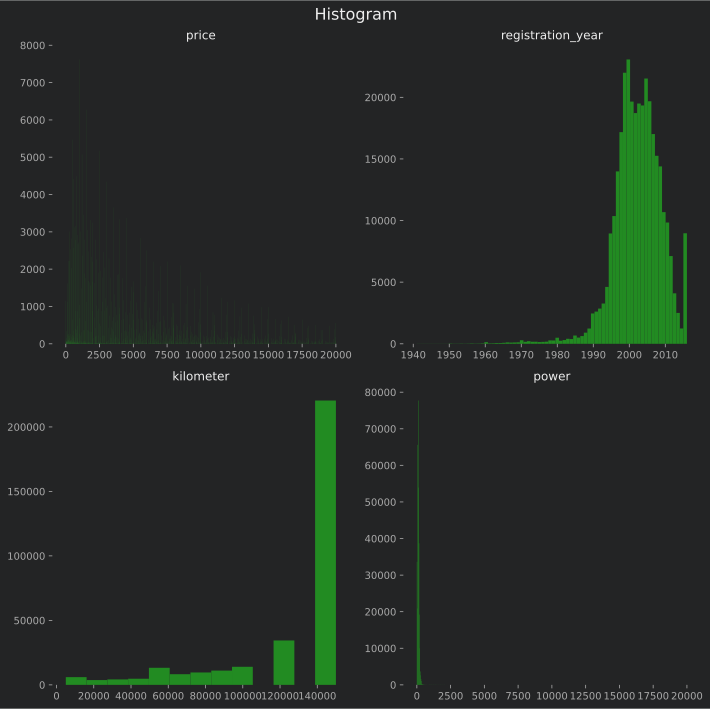

In [19]:
plot_hist(data=autos_df.loc[
    (autos_df['registration_year'] < 2017)
    & (autos_df['registration_year'] > 1940),
        [
            'price',
            'registration_year',
             'kilometer',
             'power',
        ]
   ]
)

<hr>

## 2. Подготовим данные

In [42]:
categorical_col = {
    'vehicle_type': 'category',
    'gearbox': 'category',
    'model': 'category',
    'fuel_type': 'category',
    'brand': 'category',
    'repaired': 'category',
    'postal_code': 'category',
}

numeric_col = [
    'price',
    'power',
    'kilometer',
    'registration_year',
    'registration_month',
]

col_types = {
        'price': 'uint32',
        'power': 'uint16',
        'kilometer': 'uint32',
        'registration_year': 'uint16',
        'registration_month': 'uint8',
}

In [43]:
def descr_intervals(data_df, title='99% и 95% интервалы', perc=[.005, .025,  .5, .975, .995]):
    print(title)

    display(
        pd.DataFrame(
            data=data_df.describe(percentiles=perc).values,
            index=data_df.describe(percentiles=perc).index,
            columns=data_df.columns
        )
    )

In [59]:
def idx_by_quantiles (data_df, col_list, start_quant=.005, end_quant=.995):
    '''idx_by_quantiles returns combined inexes of given DataFrame by quantiles'''
    # col_list = pd.Series(col_list)
    idx_to_return = []
    for column in col_list:
        # print(len(idx_to_return))
        idx_to_return.extend(
            # list(
                data_df.loc[
                    (data_df[column] >= data_df[column].quantile(start_quant))
                    & (data_df[column] <= data_df[column].quantile(end_quant))
                ].index
            # )
        )
    return len(set(idx_to_return))
        

In [60]:
idx_by_quantiles(autos_df, numeric_col) / start_df_length

0.9696023071995575

In [34]:
descr_intervals(
    autos_df.loc[: , numeric_col]
)

99% и 95% интервалы


,price,power,kilometer,registration_year,registration_month
count,343597.000000,343597.000000,343597.000000,343597.000000,343597.000000
mean,4555.121974,111.000192,128337.616452,2004.089797,5.777891
std,4515.058553,188.177974,37521.047429,78.413225,3.698186
min,1.000000,0.000000,5000.000000,1000.000000,0.000000
0.5%,50.000000,0.000000,5000.000000,1972.000000,0.000000
2.5%,200.000000,0.000000,20000.000000,1989.000000,0.000000
50%,2890.000000,105.000000,150000.000000,2003.000000,6.000000
97.5%,16950.000000,241.000000,150000.000000,2017.000000,12.000000
99.5%,19500.000000,334.000000,150000.000000,2018.000000,12.000000
max,20000.000000,20000.000000,150000.000000,9999.000000,12.000000


In [15]:
list(autos_df.columns)

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'postal_code']

date_crawled
price
vehicle_type
registration_year
gearbox
power
model
kilometer
registration_month
fuel_type
brand
repaired
date_created
number_of_pictures
postal_code
last_see

In [18]:
missed_rows = autos_df.loc[
            (autos_df['gearbox'].isna())
            & (autos_df['model'].isna())
            & (autos_df['vehicle_type'].isna())
            & (autos_df['fuel_type'].isna())
        ].index

print('Строк с пропусками сразу 4-ёх параметров →', len(missed_rows))
print('Всего навсего {:.2%}'.format(len(missed_rows) / len(autos_df.index)))

Строк с пропусками сразу 4-ёх параметров → 2392
Всего навсего 0.68%


Удалим строки где сразу 4 пераметра `NaN`

In [19]:
autos_df.drop(
    index=missed_rows,
    inplace=True
)

In [20]:
display(
    len(
        autos_df.loc[
            autos_df['registration_year'] > 2016
        ].index
    )
)

14302

> On January 29, 1886, Carl Benz applied for a patent for his “vehicle powered by a gas engine.”  

© [mercedes-benz.com](https://group.mercedes-benz.com/company/tradition/company-history/1885-1886.html)

In [36]:
display(
    len(
        autos_df.loc[
            autos_df['registration_year'] < 1972
        ].index
    )
)

1618

In [37]:
display(
    autos_df.loc[
        autos_df['registration_year'] < 1957,
        [
            'price',
            'registration_year',
             'registration_month',
             'repaired',
             'brand',
             'model',
             'vehicle_type',
             'kilometer',
             'gearbox',
             'power',
             'fuel_type',
             'date_created',
        ]
    ]
)

,price,registration_year,registration_month,repaired,brand,model,vehicle_type,kilometer,gearbox,power,fuel_type,date_created
15,450,1910,0,NaN,ford,ka,small,5000,NaN,0,petrol,2016-03-11 00:00:00
1928,7000,1945,2,no,volkswagen,other,suv,150000,manual,48,petrol,2016-03-25 00:00:00
2273,1800,1925,1,no,sonstige_autos,NaN,convertible,5000,NaN,0,NaN,2016-03-15 00:00:00
3333,10500,1955,0,NaN,ford,other,sedan,60000,manual,30,petrol,2016-03-15 00:00:00
6977,135,1910,0,NaN,opel,NaN,NaN,5000,NaN,0,NaN,2016-03-24 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
351183,17500,1954,7,no,citroen,other,sedan,20000,manual,52,petrol,2016-03-27 00:00:00
351299,5500,1956,4,no,sonstige_autos,NaN,bus,60000,manual,37,petrol,2016-03-09 00:00:00
351682,11500,1800,6,NaN,fiat,other,NaN,5000,NaN,16,petrol,2016-03-11 00:00:00
353531,6000,1937,0,NaN,mercedes_benz,other,sedan,5000,manual,38,petrol,2016-03-16 00:00:00


In [34]:
display(
    autos_df.loc[
        autos_df['kilometer'] <= 5000,
        [
            'price',
            'registration_year',
             'registration_month',
             'repaired',
             'brand',
             'model',
             'vehicle_type',
             'kilometer',
             'gearbox',
             'power',
             'fuel_type',
             'date_created',
        ]
    ]
)



,price,registration_year,registration_month,repaired,brand,model,vehicle_type,kilometer,gearbox,power,fuel_type,date_created
15,450,1910,0,NaN,ford,ka,small,5000,NaN,0,petrol,2016-03-11 00:00:00
28,1990,1981,1,no,volkswagen,transporter,bus,5000,manual,50,petrol,2016-03-09 00:00:00
52,1400,2016,1,NaN,hyundai,other,NaN,5000,manual,55,NaN,2016-04-04 00:00:00
111,0,2017,12,NaN,volkswagen,golf,NaN,5000,manual,0,petrol,2016-03-19 00:00:00
115,0,1999,0,NaN,volkswagen,NaN,small,5000,NaN,0,petrol,2016-03-20 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
353825,1600,2018,5,no,volkswagen,lupo,NaN,5000,manual,0,petrol,2016-03-08 00:00:00
353865,15500,1973,3,no,ford,other,coupe,5000,manual,0,petrol,2016-03-15 00:00:00
353961,200,1910,0,NaN,sonstige_autos,NaN,NaN,5000,NaN,0,petrol,2016-03-17 00:00:00
354079,10985,2015,11,no,peugeot,1_reihe,small,5000,manual,82,petrol,2016-03-31 00:00:00


In [18]:
display(
    autos_df.info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351977 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        351977 non-null  object
 1   price               351977 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   351977 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               351977 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           351977 non-null  int64 
 8   registration_month  351977 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               351977 non-null  object
 11  repaired            283060 non-null  object
 12  date_created        351977 non-null  object
 13  number_of_pictures  351977 non-null  int64 
 14  postal_code         351977 non-null  int64 
 15  last_seen           351977 non-null  object
dtypes:

None

In [21]:
display(
    autos_df['gearbox'].unique()
)

array(['manual', 'auto', nan], dtype=object)

 10.58%	→ vehicle_type → 37490
 5.60%	→ gearbox → 19833
 5.56%	→ model → 19705
 9.28%	→ fuel_type → 32895
 20.08%	→ repaired → 71154

In [30]:
display(
    autos_df.groupby(
        by=['model', 'fuel_type', 'vehicle_type'],
        observed=True,
    ).sum()
)

/tmp/ipykernel_9676/3299655829.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).sum()


price  registration_year  power  kilometer  \
model  fuel_type vehicle_type                                                
100    gasoline  convertible     7190               2007    163     150000   
                 sedan          12650              13917    668    1025000   
                 wagon          13297              13954    690     990000   
       lpg       sedan          11491              11945    713     900000   
                 wagon           3316               3987    300     300000   
...                               ...                ...    ...        ...   
zafira petrol    other          37039              20026    780    1100000   
                 sedan          20059              22015   1108    1480000   
                 small          10590              10013    530     560000   
                 suv             5540               6005    150     305000   
                 wagon         198712             158119   8537   10835000   

                               registration_month  number_of_pictures  \
model  fuel_type vehicle_type                                           
100    gasoline  convertible                   10                   0   
                 sedan                         35                   0   
                 wagon                         31                   0   
       lpg       sedan                         25                   0   
                 wagon                         16                   0   
...                                           ...                 ...   
zafira petrol    other                         47                   0   
                 sedan                         68                   0   
                 small                         29                   0   
                 suv                            8                   0   
                 wagon                        454                   0   

                               postal_code  
model  fuel_type vehicle_type               
100    gasoline  convertible         49205  
                 sedan              298864  
                 wagon              408348  
       lpg       sedan              285516  
                 wagon               63113  
...                                    ...  
zafira petrol    other              383125  
                 sedan              576155  
                 small              267361  
                 suv                175851  
                 wagon             3693200  

[2285 rows x 7 columns]

### 2.1. Заполним пропущенные значения и обработаем аномалии в данных

> Заполните пропущенные значения и обработайте аномалии в столбцах.

### 2.2. Создадим информативные признаки из неинформативных

У нас есть время загрузки анкет, время создания анкет и время последнего визита. Из этих данных можно узнать как долго анкеты на сайте и как долго отсутствовал владельц на сайте.  
Можно предположить что чем дольше анкета на сайте и чем реже заходит владелец тем выше цена или хуже состояние машины за эти деньги.  
Оставим на десерт.

### 2.3. Удалим неинформативные признаки

> Если среди признаков имеются неинформативные, удалите их.

Основные шаги:

- Загрузите данные, путь к файлу: /datasets/autos.csv.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.